In [19]:
import numpy as np
import pandas as pd
import shap
import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn.inspection import PartialDependenceDisplay
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score, log_loss, precision_score, recall_score, f1_score, \
    brier_score_loss, roc_curve, average_precision_score
from scipy.stats import ks_2samp
from xgboost import XGBClassifier
from sklearn.model_selection import ParameterGrid
import os
import pickle

# VisionPermutator 类定义 (保持不变)
class VisionPermutator(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.scaler = StandardScaler()
        self.minmax_scaler = MinMaxScaler()
        self.robust_scaler = RobustScaler()
        self.selector = SelectFromModel(LogisticRegression(penalty="l1", solver="liblinear"))
        self.feature_mapping = {}

    def fit(self, X, y=None):
        self.scaler.fit(X)
        self.minmax_scaler.fit(X)
        self.robust_scaler.fit(X)
        self.selector.fit(X, y)
        return self

    def transform(self, X):
        X_scaled = self.scaler.transform(X)
        X_minmax = self.minmax_scaler.transform(X)
        X_robust = self.robust_scaler.transform(X)
        X_selected = self.selector.transform(X)

        # 记录原始特征的映射
        self.record_feature_mapping(X, X_scaled, 'scaled')
        self.record_feature_mapping(X, X_minmax, 'minmax')
        self.record_feature_mapping(X, X_robust, 'robust')
        self.record_feature_mapping(X, X_selected, 'selected')

        X_selected_expanded = self.expand_selected_features(X_selected, X.shape[1])

        X_transformed = self.permute_mlp(pd.DataFrame(X_scaled, columns=X.columns),
                                         pd.DataFrame(X_minmax, columns=X.columns),
                                         pd.DataFrame(X_robust, columns=X.columns),
                                         pd.DataFrame(X_selected_expanded, columns=X.columns))
        self.update_feature_mapping(X_transformed, X.columns)
        return X_transformed

    def record_feature_mapping(self, original_X, transformed_X, method):
        for i in range(transformed_X.shape[1]):
            original_feature = original_X.columns[i % original_X.shape[1]]
            self.feature_mapping[f'{method}_feature_{i}'] = original_feature

    def expand_selected_features(self, X_selected, n_features):
        expanded_features = np.zeros((X_selected.shape[0], n_features))
        selected_indices = np.where(self.selector.get_support())[0]
        for i, col_idx in enumerate(selected_indices):
            expanded_features[:, col_idx] = X_selected[:, i]
        return expanded_features

    def permute_mlp(self, X_scaled, X_minmax, X_robust, X_selected):
        X_height = self.encode_height(X_scaled, X_minmax, X_robust, X_selected)
        X_width = self.encode_width(X_scaled, X_minmax, X_robust, X_selected)
        X_weighted = self.weighted_permute_mlp(X_height, X_width)
        return X_weighted

    def encode_height(self, X_scaled, X_minmax, X_robust, X_selected):
        X_height_encoded = X_scaled.apply(lambda row: self.linear_projection(row, axis=0), axis=1)
        X_height_encoded += X_minmax.apply(lambda row: self.polynomial_projection(row, axis=0), axis=1)
        X_height_encoded += X_robust.apply(lambda row: self.nonlinear_projection(row, axis=0), axis=1)
        X_height_encoded += X_selected.apply(lambda row: self.selected_projection(row, axis=0), axis=1)
        return pd.DataFrame(X_height_encoded.tolist(), index=X_scaled.index)

    def encode_width(self, X_scaled, X_minmax, X_robust, X_selected):
        X_width_encoded = X_scaled.apply(lambda row: self.linear_projection(row, axis=1), axis=1)
        X_width_encoded += X_minmax.apply(lambda row: self.polynomial_projection(row, axis=1), axis=1)
        X_width_encoded += X_robust.apply(lambda row: self.nonlinear_projection(row, axis=1), axis=1)
        X_width_encoded += X_selected.apply(lambda row: self.selected_projection(row, axis=1), axis=1)
        return pd.DataFrame(X_width_encoded.tolist(), index=X_scaled.index)

    def linear_projection(self, row, axis):
        projection_vector = np.random.rand(row.shape[0])
        if axis == 0:
            projection = np.dot(row.values.reshape(-1, 1), projection_vector.reshape(1, -1))
        elif axis == 1:
            projection = np.dot(projection_vector.reshape(-1, 1), row.values.reshape(1, -1))
        projection = projection / np.linalg.norm(projection)  # 正则化
        return projection.flatten()

    def polynomial_projection(self, row, axis, degree=2):
        projection_vector = np.random.rand(row.shape[0])
        if axis == 0:
            projection = np.dot(row.values.reshape(-1, 1) ** degree, projection_vector.reshape(1, -1))
        elif axis == 1:
            projection = np.dot(projection_vector.reshape(-1, 1) ** degree, row.values.reshape(1, -1))
        projection = projection / np.linalg.norm(projection)  # 正则化
        return projection.flatten()

    def nonlinear_projection(self, row, axis):
        projection_vector = np.random.rand(row.shape[0])
        if axis == 0:
            projection = np.dot(np.sin(row.values.reshape(-1, 1)), projection_vector.reshape(1, -1))
        elif axis == 1:
            projection = np.dot(projection_vector.reshape(-1, 1), np.sin(row.values.reshape(1, -1)))
        projection = projection / np.linalg.norm(projection)  # 正则化
        return projection.flatten()

    def selected_projection(self, row, axis):
        projection_vector = np.random.rand(row.shape[0])
        if axis == 0:
            projection = np.dot(row.values.reshape(-1, 1), projection_vector.reshape(1, -1))
        elif axis == 1:
            projection = np.dot(projection_vector.reshape(-1, 1), row.values.reshape(1, -1))
        projection = projection / np.linalg.norm(projection)  # 正则化
        return projection.flatten()

    def weighted_permute_mlp(self, X_height, X_width):
        weight_height = np.random.rand()
        weight_width = 1 - weight_height
        X_weighted = weight_height * X_height + weight_width * X_width
        return X_weighted

    def update_feature_mapping(self, X_transformed, original_columns):
        for i in range(X_transformed.shape[1]):
            original_feature = original_columns[i % len(original_columns)]
            self.feature_mapping[f'feature_{i}'] = original_feature

In [20]:
root_path = 'D:/study/Credit(1)/Credit/'
params_path = r'D:\study\Credit(1)\Credit\params/'
dataset_path = r'D:\study\credit_scoring_datasets/'
shuffle_path = r'D:\study\Credit(1)\Credit\shuffle_index/'
save_path = r'D:\study\second\outcome/'
os.makedirs(save_path, exist_ok=True)

In [21]:
data = pd.read_csv(r'D:\study\credit_scroing_datasets\shandong.csv', low_memory=True)
features = data.drop('label', axis=1).replace([-np.inf, np.inf], 0).fillna(0)
labels = data['label']

# 分割数据集
train_size = int(features.shape[0] * 0.8)
valid_size = int(features.shape[0] * 0.1)
test_size = valid_size  # 假设测试集大小与验证集相同


In [22]:
with open(shuffle_path + 'shandong/shuffle_index.pickle', 'rb') as f:
    shuffle_index = pickle.load(f)

train_index = shuffle_index[:train_size]
valid_index = shuffle_index[train_size:(train_size + valid_size)]
test_index = shuffle_index[(train_size + valid_size):(train_size + valid_size + test_size)]

train_x, train_y = features.iloc[train_index, :], labels.iloc[train_index]
valid_x, valid_y = features.iloc[valid_index, :], labels.iloc[valid_index]
test_x, test_y = features.iloc[test_index, :], labels.iloc[test_index]

In [23]:
full_train_x = pd.concat([train_x, valid_x], axis=0)
full_train_y = pd.concat([train_y, valid_y], axis=0)

# 初始化 VisionPermutator 并转换数据
vp = VisionPermutator()
vp.fit(full_train_x, full_train_y)
full_train_x_transformed = vp.transform(full_train_x)
test_x_transformed = vp.transform(test_x)

# 确保转换后的数据为数值型
full_train_x_transformed = full_train_x_transformed.astype(float)
test_x_transformed = test_x_transformed.astype(float)

# 训练 XGBoost 模型


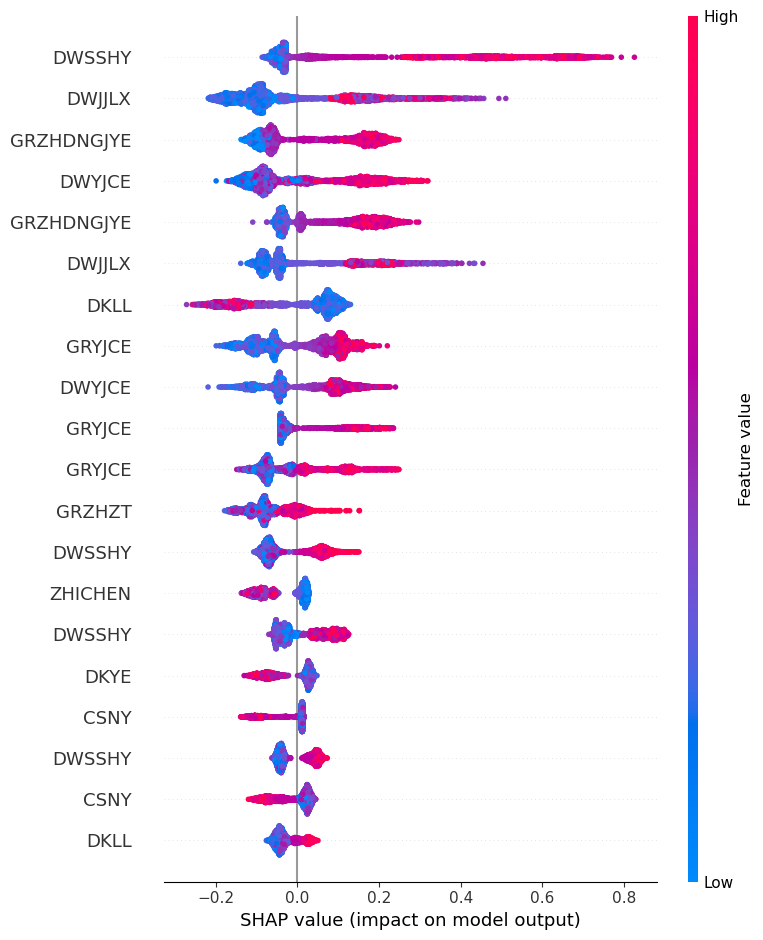

In [25]:
# 初始化并训练 XGBoost 模型
xgb_model = XGBClassifier(
    n_estimators=500,          # 树的数量
    max_depth=3,               # 树的最大深度
    learning_rate=0.01,        # 学习率
    reg_lambda=10,             # L2 正则化
    subsample=0.8,             # 子样本比例
    colsample_bytree=0.8,      # 每棵树使用的特征比例
    tree_method='hist',        # 树的方法
    booster='gbtree',          # 提升方法
    objective='binary:logistic'  # 目标函数
)

xgb_model.fit(full_train_x_transformed, full_train_y)

# 使用 SHAP 进行解释
explainer = shap.TreeExplainer(xgb_model)
shap_values = explainer.shap_values(test_x_transformed)

# 准备特征映射列表
feature_names = [vp.feature_mapping.get(f'feature_{i}', f'feature_{i}') for i in range(test_x_transformed.shape[1])]

# 显示 SHAP summary plot
shap.summary_plot(shap_values, test_x_transformed, feature_names=feature_names)

# 显示第一个测试样本的 SHAP force plot
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[0], test_x_transformed.iloc[0], feature_names=feature_names)


In [26]:
print(vp.feature_mapping)

# 查找 feature_162 对应的原始特征
original_feature = vp.feature_mapping.get('feature_162')
print(f'Feature 162 对应的原始特征是: {original_feature}')

{'scaled_feature_0': 'XINGBIE', 'scaled_feature_1': 'CSNY', 'scaled_feature_2': 'HYZK', 'scaled_feature_3': 'ZHIYE', 'scaled_feature_4': 'ZHICHEN', 'scaled_feature_5': 'ZHIWU', 'scaled_feature_6': 'XUELI', 'scaled_feature_7': 'DWJJLX', 'scaled_feature_8': 'DWSSHY', 'scaled_feature_9': 'GRJCJS', 'scaled_feature_10': 'GRZHZT', 'scaled_feature_11': 'GRZHYE', 'scaled_feature_12': 'GRZHSNJZYE', 'scaled_feature_13': 'GRZHDNGJYE', 'scaled_feature_14': 'GRYJCE', 'scaled_feature_15': 'DWYJCE', 'scaled_feature_16': 'DKFFE', 'scaled_feature_17': 'DKYE', 'scaled_feature_18': 'DKLL', 'minmax_feature_0': 'XINGBIE', 'minmax_feature_1': 'CSNY', 'minmax_feature_2': 'HYZK', 'minmax_feature_3': 'ZHIYE', 'minmax_feature_4': 'ZHICHEN', 'minmax_feature_5': 'ZHIWU', 'minmax_feature_6': 'XUELI', 'minmax_feature_7': 'DWJJLX', 'minmax_feature_8': 'DWSSHY', 'minmax_feature_9': 'GRJCJS', 'minmax_feature_10': 'GRZHZT', 'minmax_feature_11': 'GRZHYE', 'minmax_feature_12': 'GRZHSNJZYE', 'minmax_feature_13': 'GRZHDNGJ

In [27]:
from sklearn.metrics import accuracy_score, roc_auc_score, log_loss, precision_score, recall_score, f1_score, \
    brier_score_loss, roc_curve, average_precision_score

# 使用 XGBoost 模型进行预测
train_pred = xgb_model.predict(full_train_x_transformed)
train_pred_proba = xgb_model.predict_proba(full_train_x_transformed)[:, 1]
test_pred = xgb_model.predict(test_x_transformed)
test_pred_proba = xgb_model.predict_proba(test_x_transformed)[:, 1]

# 计算训练集和测试集上的各项指标
metrics = {
    'accuracy': accuracy_score,
    'roc_auc': roc_auc_score,
    'log_loss': log_loss,
    'precision': precision_score,
    'recall': recall_score,
    'f1_score': f1_score,
    'brier_score': brier_score_loss,
    'average_precision': average_precision_score
}

def compute_metrics(true_labels, pred_labels, pred_proba):
    results = {}
    for name, metric in metrics.items():
        if name in ['log_loss', 'brier_score']:
            results[name] = metric(true_labels, pred_proba)
        else:
            results[name] = metric(true_labels, pred_labels)
    return results

train_metrics = compute_metrics(full_train_y, train_pred, train_pred_proba)
test_metrics = compute_metrics(test_y, test_pred, test_pred_proba)

# 打印训练集和测试集上的指标
print("Train Metrics:")
for metric, value in train_metrics.items():
    print(f"{metric}: {value:.4f}")

print("\nTest Metrics:")
for metric, value in test_metrics.items():
    print(f"{metric}: {value:.4f}")


Train Metrics:
accuracy: 0.9455
roc_auc: 0.6283
log_loss: 0.1689
precision: 0.8427
recall: 0.2602
f1_score: 0.3977
brier_score: 0.0455
average_precision: 0.2705

Test Metrics:
accuracy: 0.9407
roc_auc: 0.5857
log_loss: 0.1918
precision: 0.7344
recall: 0.1760
f1_score: 0.2840
brier_score: 0.0504
average_precision: 0.1843


In [18]:
print(vp.feature_mapping)

# 查找 feature_162 对应的原始特征
original_feature = vp.feature_mapping.get('feature_162')
print(f'Feature 162 对应的原始特征是: {original_feature}')

{'scaled_feature_0': 'XINGBIE', 'scaled_feature_1': 'CSNY', 'scaled_feature_2': 'HYZK', 'scaled_feature_3': 'ZHIYE', 'scaled_feature_4': 'ZHICHEN', 'scaled_feature_5': 'ZHIWU', 'scaled_feature_6': 'XUELI', 'scaled_feature_7': 'DWJJLX', 'scaled_feature_8': 'DWSSHY', 'scaled_feature_9': 'GRJCJS', 'scaled_feature_10': 'GRZHZT', 'scaled_feature_11': 'GRZHYE', 'scaled_feature_12': 'GRZHSNJZYE', 'scaled_feature_13': 'GRZHDNGJYE', 'scaled_feature_14': 'GRYJCE', 'scaled_feature_15': 'DWYJCE', 'scaled_feature_16': 'DKFFE', 'scaled_feature_17': 'DKYE', 'scaled_feature_18': 'DKLL', 'minmax_feature_0': 'XINGBIE', 'minmax_feature_1': 'CSNY', 'minmax_feature_2': 'HYZK', 'minmax_feature_3': 'ZHIYE', 'minmax_feature_4': 'ZHICHEN', 'minmax_feature_5': 'ZHIWU', 'minmax_feature_6': 'XUELI', 'minmax_feature_7': 'DWJJLX', 'minmax_feature_8': 'DWSSHY', 'minmax_feature_9': 'GRJCJS', 'minmax_feature_10': 'GRZHZT', 'minmax_feature_11': 'GRZHYE', 'minmax_feature_12': 'GRZHSNJZYE', 'minmax_feature_13': 'GRZHDNGJ